In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from scipy.io import loadmat
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import os

In [5]:
# Load the MATLAB file
data = pd.read_csv(r'K:\chalmers\DML\Project_DML\DML-Project\Battery_data\B0005_discharge_.csv')
data.head(10)

,cycle,ambient_temperature,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time,RUL
0,1,24,1.856487,4.191492,-0.004902,24.330034,-0.0006,0.000,0.000,167
1,1,24,1.856487,4.190749,-0.001478,24.325993,-0.0006,4.206,16.781,167
2,1,24,1.856487,3.974871,-2.012528,24.389085,-1.9982,3.062,35.703,167
3,1,24,1.856487,3.951717,-2.013979,24.544752,-1.9982,3.030,53.781,167
4,1,24,1.856487,3.934352,-2.011144,24.731385,-1.9982,3.011,71.922,167
5,1,24,1.856487,3.920058,-2.013007,24.909816,-1.9982,2.991,90.094,167
6,1,24,1.856487,3.907904,-2.014400,25.105884,-1.9982,2.977,108.281,167
7,1,24,1.856487,3.897036,-2.011603,25.317019,-1.9982,2.967,126.453,167
8,1,24,1.856487,3.887477,-2.018015,25.509423,-1.9982,2.959,144.641,167
9,1,24,1.856487,3.878959,-2.013135,25.703603,-1.9982,2.951,162.844,167


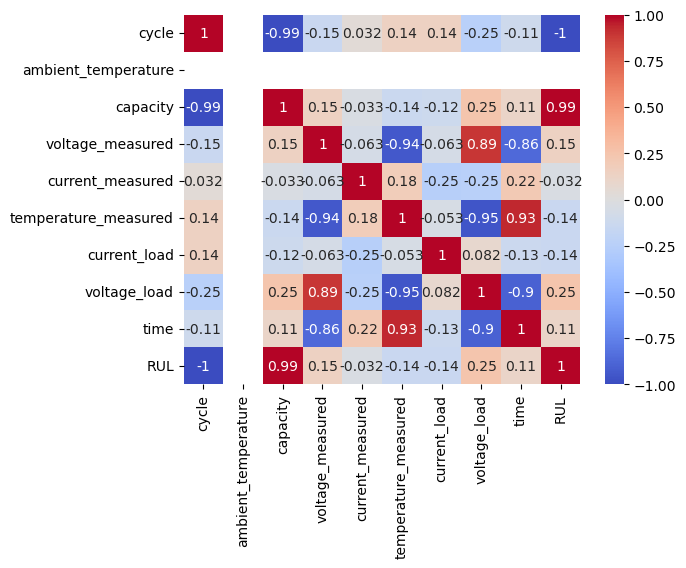

In [6]:
corr = data.corr(method='spearman') 
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [12]:
target_col = ['capacity', 'RUL', 'cycle','ambient_temperature']
X = data.drop(columns=target_col)
y = data[target_col]

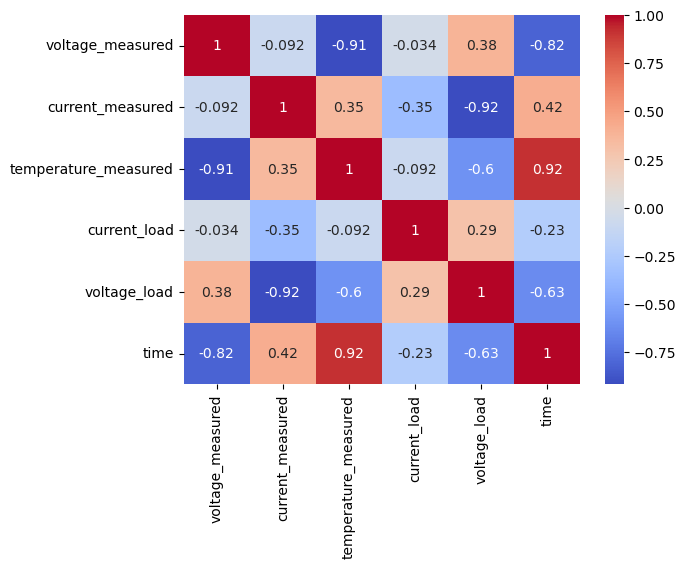

In [14]:
corr = X.corr(method='pearson') 
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

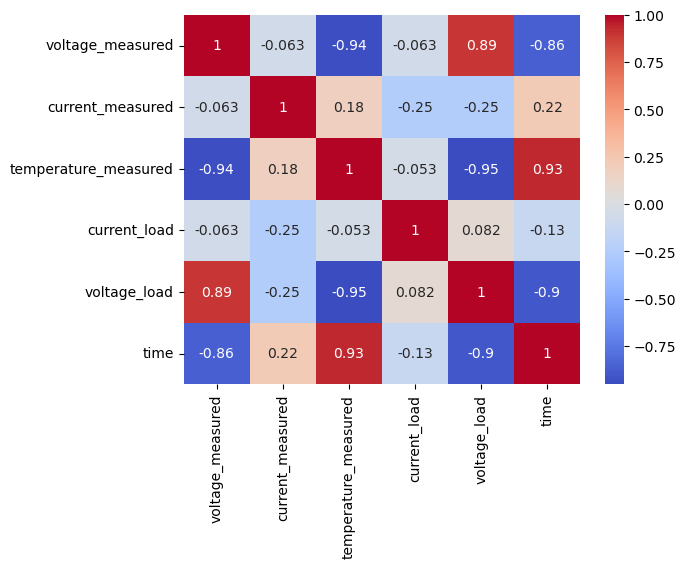

In [15]:
corr = X.corr(method='spearman') 
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [65]:
path = r"K:\chalmers\DML\Project_DML\DML-Project\Battery_data"
all_files = [f for f in os.listdir(path) if f.endswith('.csv')]
print("CSV files:", all_files)

battery_ids = [f.split('.')[0] for f in all_files]  # ['B0005_discharge', 'B0006_discharge', ...]
print(battery_ids)

battery_list = []
cycle_counts = []

for f in all_files:
    df = pd.read_csv(os.path.join(path, f))
    battery_list.append(f.split('.')[0])
    cycle_counts.append(df['cycle'].nunique())  # number of unique cycles in CSV

# Create DataFrame
battery_cycle_df = pd.DataFrame({'Battery': battery_list, 'Cycle': cycle_counts})
battery_cycle_df = battery_cycle_df.sort_values('Battery').drop_duplicates()
battery_cycle_df


CSV files: ['B0005_discharge_.csv', 'B0006_discharge_.csv', 'B0007_discharge.csv', 'B0018_discharge_.csv']
['B0005_discharge_', 'B0006_discharge_', 'B0007_discharge', 'B0018_discharge_']


,Battery,Cycle
0,B0005_discharge_,168
1,B0006_discharge_,168
2,B0007_discharge,168
3,B0018_discharge_,132


In [66]:


# ==========================
# CONFIGURATION
# ==========================
path = r"K:\chalmers\DML\Project_DML\DML-Project\Battery_data"

# Define battery groups (experiments)
#experiment1 = ["B0005", "B0006", "B0007", "B0018"]
data_set = ["B0006"]

df_all = pd.DataFrame()
max_len = 0

for bat in data_set:
    # Find the CSV file for this battery
    file_name = [f for f in os.listdir(path) if bat in f and f.endswith('.csv')][0]
    df_bat = pd.read_csv(os.path.join(path, file_name))
    
    # Select relevant columns
    cols = ['voltage_measured','current_measured','temperature_measured',
            'current_load','voltage_load','time','capacity','ambient_temperature','cycle']
    df_bat = df_bat[cols]
    
    # Update max sequence length per cycle (optional, useful for LSTM)
    max_l = df_bat.groupby('cycle').size().max()
    max_len = max(max_l, max_len)
    
    # Add battery ID as a column
    df_bat['Battery'] = bat
    
    # Append to combined DataFrame
    df_all = pd.concat([df_all, df_bat], ignore_index=True)

# ==========================
df_all = df_all.reset_index(drop=True)

print("Combined DataFrame shape:", df_all.shape)
print("Maximum cycle length:", max_len)
print(df_all.head())


Combined DataFrame shape: (50285, 10)
Maximum cycle length: 371
   voltage_measured  current_measured  temperature_measured  current_load  \
0          4.179800         -0.002366             24.277568       -0.0006   
1          4.179823          0.000434             24.277073       -0.0006   
2          3.966528         -2.014242             24.366226       -1.9990   
3          3.945886         -2.008730             24.515123       -1.9990   
4          3.930354         -2.013381             24.676053       -1.9990   

   voltage_load    time  capacity  ambient_temperature  cycle Battery  
0         0.000   0.000  2.035338                   24      1   B0006  
1         4.195  16.781  2.035338                   24      1   B0006  
2         3.070  35.703  2.035338                   24      1   B0006  
3         3.045  53.781  2.035338                   24      1   B0006  
4         3.026  71.922  2.035338                   24      1   B0006  


In [69]:

feature_cols = ['voltage_measured','current_measured','temperature_measured',
                'current_load','voltage_load','time']

target_col = 'capacity'
scalar_col = 'ambient_temperature'  # optional feature per timestep

# --------------------------
max_len = df_all.groupby(['Battery','cycle']).size().max()
print("Maximum sequence length per cycle:", max_len)

# --------------------------
groups = df_all.groupby(['Battery','cycle'])
n_cycles = len(groups)
n_features = len(feature_cols)

X_cycles = np.zeros((n_cycles, max_len, n_features))
y_cycles = np.zeros(n_cycles)
ambient_cycles = np.zeros(n_cycles)

for idx, ((bat, cyc), group) in enumerate(groups):
    seq_len = len(group)
    # Fill features
    X_cycles[idx, :seq_len, :] = group[feature_cols].values
    # Fill target (take first value for the cycle)
    y_cycles[idx] = group[target_col].values[0]
    # Ambient temperature (scalar per cycle)
    ambient_cycles[idx] = group[scalar_col].values[0]

# --------------------------
# 4️⃣ Add ambient temperature as a feature
# --------------------------
ambient_expanded = np.tile(ambient_cycles[:, np.newaxis, np.newaxis], (1, max_len, 1))
X_cycles_final = np.concatenate([X_cycles, ambient_expanded], axis=2)

print("LSTM-ready input shape:", X_cycles_final.shape)
print("Target shape:", y_cycles.shape)

Maximum sequence length per cycle: 371
LSTM-ready input shape: (168, 371, 7)
Target shape: (168,)


Train X: (100, 371, 7) Train y: (100, 1)
Validation X: (34, 371, 7) Validation y: (34, 1)
Test X: (34, 371, 7) Test y: (34, 1)


C:\Anaconda_DML\envs\dml\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                       │ (None, 371, 128)            │          69,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 371, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_23 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 125,313 (489.50 KB)

 Trainable params: 125,313 (489.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - loss: 0.1599 - val_loss: 0.1160
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - loss: 0.0929 - val_loss: 0.1303
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - loss: 0.0933 - val_loss: 0.1004
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - loss: 0.0778 - val_loss: 0.1050
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - loss: 0.0705 - val_loss: 0.0919
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - loss: 0.0701 - val_loss: 0.0976
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - loss: 0.0691 - val_loss: 0.0899
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - loss: 0.0705 - val_loss: 0.0939
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - loss: 0.0673 - val_loss: 0.0916
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - loss: 0.0685 - val_loss: 0.0934
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - loss: 0.0672 - val_loss: 0.0918
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - loss: 0.0

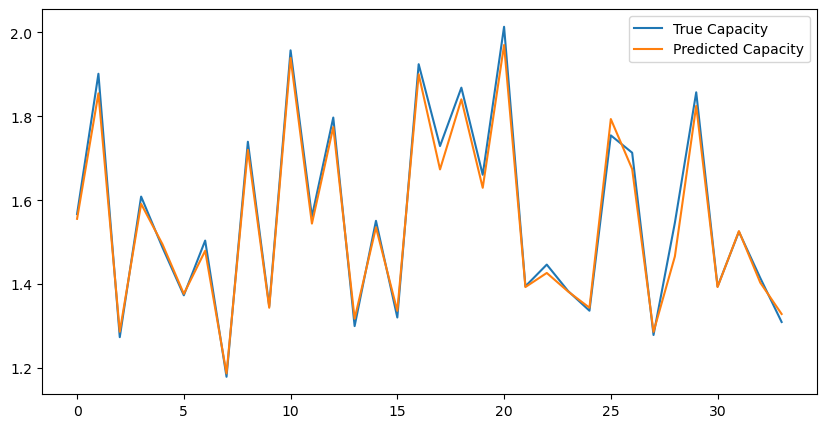

In [80]:
n_cycles, max_len, n_features = X_cycles_final.shape

# Reshape for scaler: (num_samples*time, features)
X_reshaped = X_cycles_final.reshape(-1, n_features)
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_reshaped)

# Reshape back to LSTM 3D input
X_scaled = X_scaled.reshape(n_cycles, max_len, n_features)

y = y_cycles.reshape(-1, 1)  # 2D for scaler
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

# ===============================
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Train X:", X_train.shape, "Train y:", y_train.shape)
print("Validation X:", X_val.shape, "Validation y:", y_val.shape)
print("Test X:", X_test.shape, "Test y:", y_test.shape)

"""
model = models.Sequential([
    layers.LSTM(64, return_sequences=False, input_shape=(max_len, n_features)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Output is scaled
])
"""

model = models.Sequential([
    # First LSTM returns sequences to feed next LSTM
    layers.LSTM(128, return_sequences=True, input_shape=(max_len, n_features)),
    layers.Dropout(0.2),

    # Second LSTM extracts final time information
    layers.LSTM(64, return_sequences=False),
    layers.Dropout(0.2),

    # Dense layers for nonlinearity
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Output
])


model.compile(optimizer='adam', loss='mse')
model.summary()

# ===============================
# 5️⃣ Training
# ===============================
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=32,
                    verbose=1)

# ===============================
# 6️⃣ Inverse-transform Predictions
# ===============================
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_orig = scaler_y.inverse_transform(y_test)


import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(y_test_orig, label='True Capacity')
plt.plot(y_pred, label='Predicted Capacity')
plt.legend()
plt.show()





6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


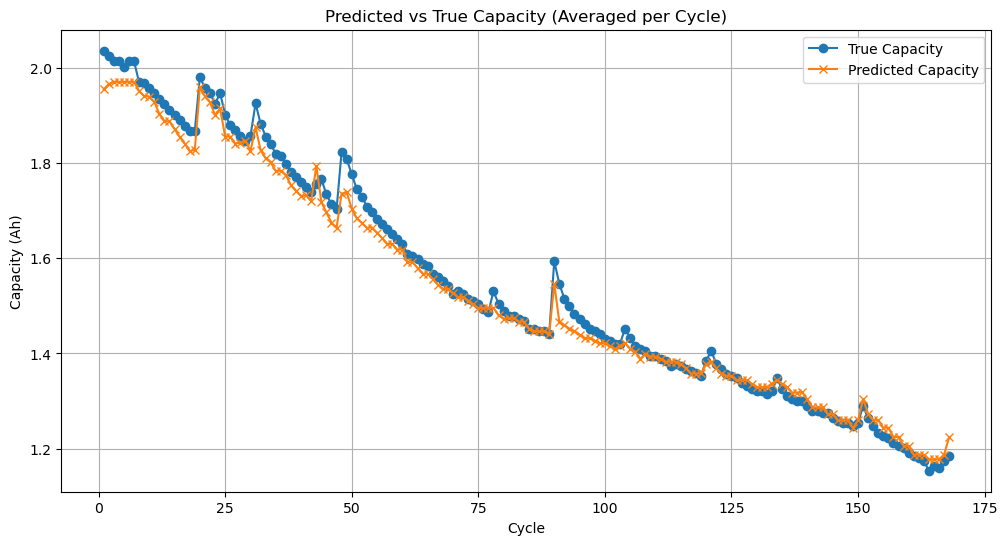

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===============================
# 1️⃣ Prepare data for prediction
# ===============================
# X_cycles_final: 3D input for LSTM (num_cycles, max_len, n_features)
# scaler_X: fitted MinMaxScaler for features
# scaler_y: fitted MinMaxScaler for target

n_cycles, max_len, n_features = X_cycles_final.shape

# Flatten 3D input to 2D for scaling
X_flat = X_cycles_final.reshape(-1, n_features)
X_scaled_flat = scaler_X.transform(X_flat)
# Reshape back to 3D for LSTM
X_scaled = X_scaled_flat.reshape(n_cycles, max_len, n_features)

# ===============================
# 2️⃣ Predict
# ===============================
y_pred_scaled = model.predict(X_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)  # unscale predictions

# ===============================
# 3️⃣ Prepare cycle numbers
# ===============================
# Make sure you have a cycle array corresponding to each sequence
# For example, if X_cycles_final was created from df_all grouped by cycle:
# cycles_array = np.array(df_all.groupby('cycle').first().index)
# Otherwise, create a simple range
cycles_array = np.arange(1, n_cycles + 1)  # replace with real cycle numbers if available

# ===============================
# 4️⃣ Aggregate per cycle
# ===============================
df_plot = pd.DataFrame({
    'cycle': cycles_array,
    'capacity': y_cycles.flatten(),
    'y_pred': y_pred.flatten()
})

cycle_mean_pred = df_plot.groupby('cycle', as_index=False)[['capacity', 'y_pred']].mean()

# ===============================
# 5️⃣ Plot
# ===============================
plt.figure(figsize=(12,6))
plt.plot(cycle_mean_pred['cycle'], cycle_mean_pred['capacity'], label='True Capacity', marker='o')
plt.plot(cycle_mean_pred['cycle'], cycle_mean_pred['y_pred'], label='Predicted Capacity', marker='x')
plt.xlabel('Cycle')
plt.ylabel('Capacity (Ah)')
plt.title('Predicted vs True Capacity (Averaged per Cycle)')
plt.legend()
plt.grid(True)
plt.show()


In [89]:
# ==========================
path = r"K:\chalmers\DML\Project_DML\DML-Project\Battery_data"

# Define battery groups (experiments)
#experiment1 = ["B0005", "B0006", "B0007", "B0018"]
data_set = ["B0005"]

df_all = pd.DataFrame()
max_len = 0

for bat in data_set:
    # Find the CSV file for this battery
    file_name = [f for f in os.listdir(path) if bat in f and f.endswith('.csv')][0]
    df_bat = pd.read_csv(os.path.join(path, file_name))
    
    # Select relevant columns
    cols = ['voltage_measured','current_measured','temperature_measured',
            'current_load','voltage_load','time','capacity','ambient_temperature','cycle']
    df_bat = df_bat[cols]
    
    # Update max sequence length per cycle (optional, useful for LSTM)
    max_l = df_bat.groupby('cycle').size().max()
    max_len = max(max_l, max_len)
    
    # Add battery ID as a column
    df_bat['Battery'] = bat
    
    # Append to combined DataFrame
    df_all = pd.concat([df_all, df_bat], ignore_index=True)

# ==========================
df_all = df_all.reset_index(drop=True)

print("Combined DataFrame shape:", df_all.shape)
print("Maximum cycle length:", max_len)
print(df_all.head())




feature_cols = ['voltage_measured','current_measured','temperature_measured',
                'current_load','voltage_load','time']

target_col = 'capacity'
scalar_col = 'ambient_temperature'  # optional feature per timestep

# --------------------------
max_len = df_all.groupby(['Battery','cycle']).size().max()
print("Maximum sequence length per cycle:", max_len)

# --------------------------
groups = df_all.groupby(['Battery','cycle'])
n_cycles = len(groups)
n_features = len(feature_cols)

X_cycles = np.zeros((n_cycles, max_len, n_features))
y_cycles = np.zeros(n_cycles)
ambient_cycles = np.zeros(n_cycles)

for idx, ((bat, cyc), group) in enumerate(groups):
    seq_len = len(group)
    # Fill features
    X_cycles[idx, :seq_len, :] = group[feature_cols].values
    # Fill target (take first value for the cycle)
    y_cycles[idx] = group[target_col].values[0]
    # Ambient temperature (scalar per cycle)
    ambient_cycles[idx] = group[scalar_col].values[0]

# --------------------------
# 4️⃣ Add ambient temperature as a feature
# --------------------------
ambient_expanded = np.tile(ambient_cycles[:, np.newaxis, np.newaxis], (1, max_len, 1))
X_cycles_final = np.concatenate([X_cycles, ambient_expanded], axis=2)

print("LSTM-ready input shape:", X_cycles_final.shape)
print("Target shape:", y_cycles.shape)

Combined DataFrame shape: (50285, 10)
Maximum cycle length: 371
   voltage_measured  current_measured  temperature_measured  current_load  \
0          4.191492         -0.004902             24.330034       -0.0006   
1          4.190749         -0.001478             24.325993       -0.0006   
2          3.974871         -2.012528             24.389085       -1.9982   
3          3.951717         -2.013979             24.544752       -1.9982   
4          3.934352         -2.011144             24.731385       -1.9982   

   voltage_load    time  capacity  ambient_temperature  cycle Battery  
0         0.000   0.000  1.856487                   24      1   B0005  
1         4.206  16.781  1.856487                   24      1   B0005  
2         3.062  35.703  1.856487                   24      1   B0005  
3         3.030  53.781  1.856487                   24      1   B0005  
4         3.011  71.922  1.856487                   24      1   B0005  
Maximum sequence length per cycle: 371
LS

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step


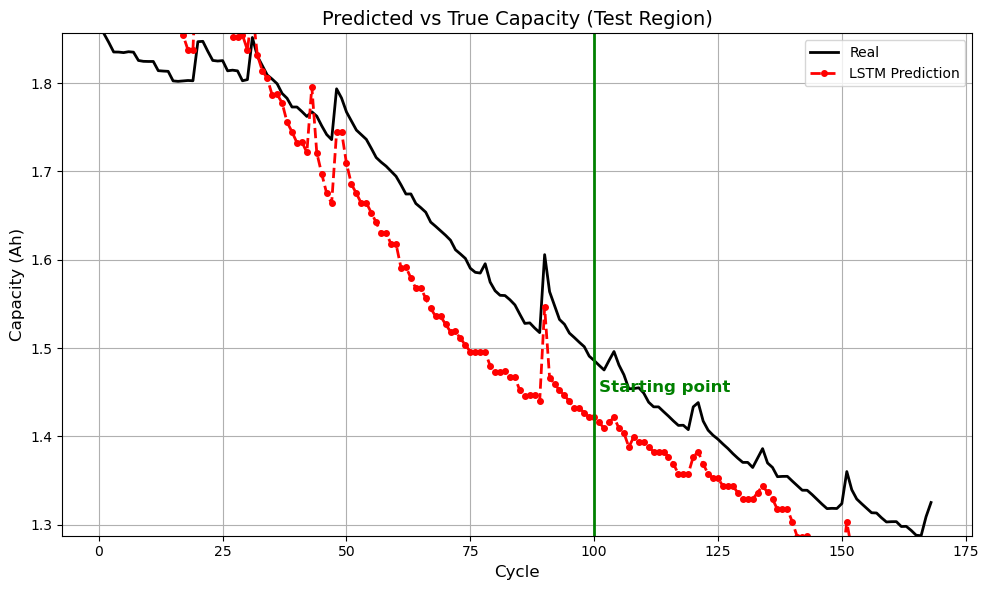

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===============================
# 1️⃣ Prepare data for prediction
# ===============================
n_cycles, max_len, n_features = X_cycles_final.shape

# Flatten 3D input to 2D for scaling
X_flat = X_cycles_final.reshape(-1, n_features)
X_scaled_flat = scaler_X.transform(X_flat)
# Reshape back to 3D for LSTM
X_scaled = X_scaled_flat.reshape(n_cycles, max_len, n_features)

# ===============================
# 2️⃣ Predict
# ===============================
y_pred_scaled = model.predict(X_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)  # unscale predictions

# ===============================
# 3️⃣ Prepare cycle numbers
# ===============================
# You can replace this with actual cycle numbers from your dataset if available
cycles_array = np.arange(1, n_cycles + 1)

# ===============================
# 4️⃣ Aggregate per cycle
# ===============================
df_plot = pd.DataFrame({
    'cycle': cycles_array,
    'capacity': y_cycles.flatten(),
    'y_pred': y_pred.flatten()
})

cycle_mean_pred = df_plot.groupby('cycle', as_index=False)[['capacity', 'y_pred']].mean()

# ===============================
# 5️⃣ Enhanced Plot (like reference figure)
# ===============================

# Define reference lines
failure_threshold = 1.4      # Adjust to your actual threshold
start_cycle = 100 if n_cycles > 100 else int(n_cycles * 0.6)  # prediction start

plt.figure(figsize=(10,6))

# True capacity (real data)
plt.plot(cycle_mean_pred['cycle'], cycle_mean_pred['capacity'],
         color='black', linewidth=2, label='Real')

# Predicted capacity
plt.plot(cycle_mean_pred['cycle'], cycle_mean_pred['y_pred'],
         color='red', linewidth=2, linestyle='--', marker='o', markersize=4, label='LSTM Prediction')

# Optional: Additional example (Baseline LSTM or other)
# plt.plot(...)

# Add reference lines
#plt.axhline(y=failure_threshold, color='teal', linewidth=2, label='Failure threshold')
plt.axvline(x=start_cycle, color='green', linewidth=2)
plt.text(start_cycle + 1, failure_threshold + 0.05, 'Starting point',
         color='green', fontsize=12, fontweight='bold')

# Formatting
plt.xlabel('Cycle', fontsize=12)
plt.ylabel('Capacity (Ah)', fontsize=12)
plt.title('Predicted vs True Capacity (Test Region)', fontsize=14)
plt.legend()
plt.grid(True)
plt.ylim(min(cycle_mean_pred['capacity'].min(), failure_threshold - 0.1),
         max(cycle_mean_pred['capacity'].max(), failure_threshold + 0.2))
plt.tight_layout()
plt.show()
